C:\Users\anith\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1/100 - accuracy: 0.5050 - loss: 0.7858 - val_accuracy: 0.5121 - val_loss: 0.7971
Epoch 2/100
2/100 - accuracy: 0.5024 - loss: 0.7892 - val_accuracy: 0.5240 - val_loss: 0.8103
Epoch 3/100
3/100 - accuracy: 0.5140 - loss: 0.7834 - val_accuracy: 0.4864 - val_loss: 0.7647
Epoch 4/100
4/100 - accuracy: 0.5264 - loss: 0.7723 - val_accuracy: 0.5367 - val_loss: 0.7826
Epoch 5/100
5/100 - accuracy: 0.5126 - loss: 0.7721 - val_accuracy: 0.5229 - val_loss: 0.8492
Epoch 6/100
6/100 - accuracy: 0.5163 - loss: 0.7712 - val_accuracy: 0.5278 - val_loss: 0.7939
Epoch 7/100
7/100 - accuracy: 0.5382 - loss: 0.7795 - val_accuracy: 0.5573 - val_loss: 0.7925
Epoch 8/100
8/100 - accuracy: 0.5338 - loss: 0.7558 - val_accuracy: 0.5275 - val_loss: 0.7710
Epoch 9/100
9/100 - accuracy: 0.5252 - loss: 0.7501 - val_accuracy: 0.5097 - val_loss: 0.7453
Epoch 10/100
10/100 - accuracy: 0.5391 - loss: 0.7402 - val_accuracy: 0.5294 - val_loss: 0.7418
Epoch 11/100
11/100 - accuracy: 0.5327 - loss: 0.7152 - va

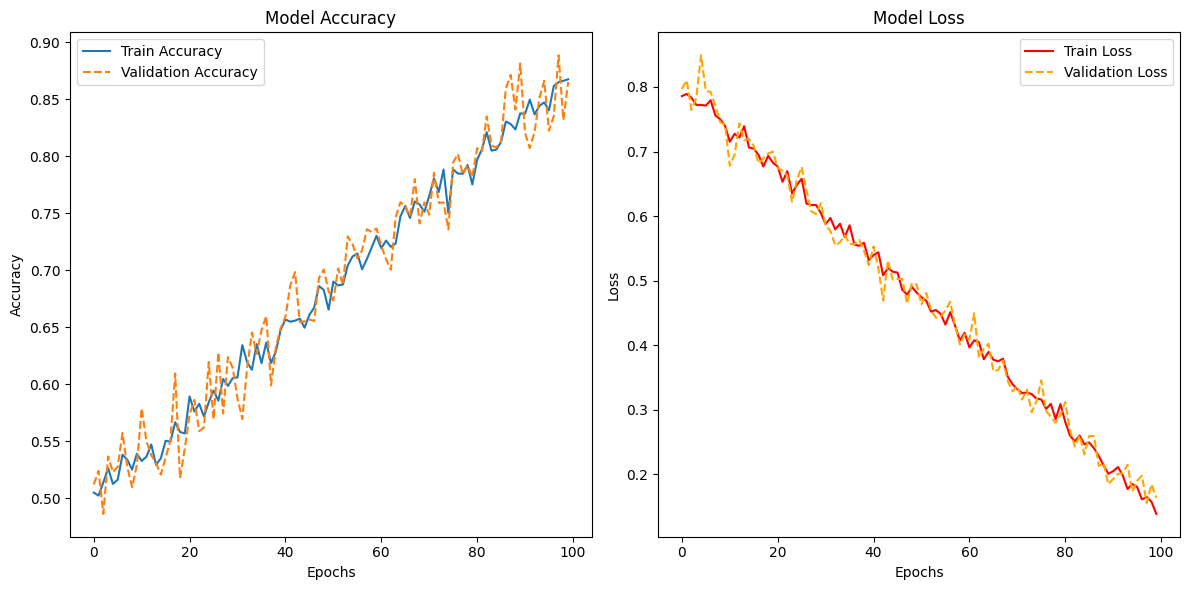

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.buildmodel import *

# Paths for different datasets based on the folder structure
calib_train_path = 'Dataset/data_object_calib/training/'
calib_test_path = 'Dataset/data_object_calib/testing/'
label_train_path = 'Dataset/data_object_label_2/training/'
velodyne_train_path = 'Dataset/velodyne/training/'
velodyne_test_path = 'Dataset/velodyne/testing/'

# Function to extract only numeric data from calibration and label files
def load_txt_file(filepath):
    numerical_data = []
    with open(filepath, 'r') as file:
        for line in file:
            # Extract numeric values while ignoring non-numeric values (e.g., 'P0:')
            numbers = [float(num) for num in line.split() if num.replace('.', '', 1).replace('-', '', 1).isdigit()]
            numerical_data.extend(numbers)

    return np.array(numerical_data, dtype=np.float32)

# Function to load Velodyne .bin files
def load_bin_file(filepath, max_points=1024):
    data = np.fromfile(filepath, dtype=np.float32)
    if len(data) > max_points:
        return data[:max_points]  # Truncate if longer
    else:
        return np.pad(data, (0, max_points - len(data)), mode='constant')  # Pad if shorter

# Function to load all data from calib, labels, and velodyne files
def load_data_from_files(calib_path, label_path, velodyne_path, max_features=1024):
    calib_files = sorted(os.listdir(calib_path))
    label_files = sorted(os.listdir(label_path))
    velodyne_files = sorted(os.listdir(velodyne_path))

    X_train = []
    Y_train = []

    for calib, label, velodyne in zip(calib_files, label_files, velodyne_files):
        calib_data = load_txt_file(os.path.join(calib_path, calib))
        label_data = load_txt_file(os.path.join(label_path, label))
        velodyne_data = load_bin_file(os.path.join(velodyne_path, velodyne), max_points=max_features)

        # Ensure all data have the same length
        calib_data = np.pad(calib_data, (0, max_features - len(calib_data)), mode='constant') if len(calib_data) < max_features else calib_data[:max_features]

        # Merge data
        X_train.append(np.concatenate((calib_data, velodyne_data)))
        Y_train.append(label_data[0] if len(label_data) > 0 else 0)  # Taking first value as label

    X_train = np.array(X_train, dtype=np.float32)
    Y_train = np.array(Y_train, dtype=np.float32)

    return X_train, Y_train

# Load training data
X_train, Y_train = load_data_from_files(calib_train_path, label_train_path, velodyne_train_path)

# Define a simple neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

class VoxelFeatureNet:
    def __init__(self, in_channels=4, out_channels=64):
        super(VoxelFeatureNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        return x

class Sparse2DBackbone:
    def __init__(self):
        super(Sparse2DBackbone, self).__init__()
        self.conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class DetectionHead:
    def __init__(self, num_classes):
        super(DetectionHead, self).__init__()
        self.cls_head = nn.Conv2d(512, num_classes, kernel_size=1)
        self.reg_head = nn.Conv2d(512, 7, kernel_size=1)  # 7 regression outputs (x, y, z, w, l, h, θ)
        
    def forward(self, x):
        cls_logits = self.cls_head(x)
        reg_outputs = self.reg_head(x)
        return cls_logits, reg_outputs

class SECOND:
    def __init__(self, num_classes=3):
        super(SECOND, self).__init__()
        self.voxel_net = VoxelFeatureNet()
        self.backbone = Sparse2DBackbone()
        self.head = DetectionHead(num_classes)
        
    def forward(self, x):
        voxel_features = self.voxel_net(x)
        features = self.backbone(voxel_features.unsqueeze(-1))
        cls_logits, reg_outputs = self.head(features)
        return cls_logits, reg_outputs


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# Train the model
model_training(epochs=100)

In [2]:
import os
import numpy as np
import open3d as o3d
import random

# Define dataset paths
dataset_root = "Dataset"  
velodyne_path = os.path.join(dataset_root, "velodyne/testing")
label_path = os.path.join(dataset_root, "data_object_label_2/training") 

# Object categories & colors
object_classes = {
    "Car": [1, 0, 0],         # Red
    "Pedestrian": [0, 1, 0],  # Green
    "Cyclist": [0, 0, 1],     # Blue
    "Truck": [1, 1, 0],       # Yellow
    "Van": [1, 0, 1],         # Magenta
    "Tram": [0, 1, 1],        # Cyan
    "Misc": [0.5, 0.5, 0.5]   # Gray
}

# Get all test sample files
bin_files = [f for f in os.listdir(velodyne_path) if f.endswith(".bin")]
random_samples = random.sample(bin_files, 2) 

def read_bin(file_path):
    """ Read point cloud from a .bin file (KITTI format) """
    return np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)  

def read_labels(label_file):
    """ Read bounding boxes from a KITTI label file & classify objects """
    boxes = []
    detected_objects = []
    with open(label_file, "r") as f:
        for line in f.readlines():
            data = line.strip().split()
            obj_class = data[0]

            # Skip "DontCare" objects
            if obj_class == "DontCare":
                continue

            # Extract 3D bounding box
            h, w, l, x, y, z, ry = map(float, data[8:15])
            color = object_classes.get(obj_class, object_classes["Misc"])  # Default to gray if unknown
            boxes.append((x, y, z, w, l, h, ry, color))
            detected_objects.append(obj_class)

    return boxes, detected_objects

def draw_bounding_boxes(vis, boxes):
    """ Add 3D bounding boxes to the Open3D visualization """
    for box in boxes:
        x, y, z, w, l, h, ry, color = box

        # Define 3D bounding box corners
        corners = np.array([
            [w/2, l/2, 0], [-w/2, l/2, 0], [-w/2, -l/2, 0], [w/2, -l/2, 0],  
            [w/2, l/2, -h], [-w/2, l/2, -h], [-w/2, -l/2, -h], [w/2, -l/2, -h]  
        ])

        # Rotate and translate
        R = np.array([[np.cos(ry), -np.sin(ry), 0], [np.sin(ry), np.cos(ry), 0], [0, 0, 1]])
        corners = (R @ corners.T).T + np.array([x, y, z])

        # Define box edges
        edges = [(0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4), (0, 4), (1, 5), (2, 6), (3, 7)]
        lines = o3d.geometry.LineSet()
        lines.points = o3d.utility.Vector3dVector(corners)
        lines.lines = o3d.utility.Vector2iVector(edges)
        lines.colors = o3d.utility.Vector3dVector([color for _ in edges]) 
        vis.add_geometry(lines)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def secd():
    dataset_path = "Dataset"
    calib_dir =  "data_object_calib"
    label_dir =  "data_object_label_2"
    velodyne_dir =  "velodyne"
    
    # Load Config File
    cfg_from_yaml_file(config_path, cfg)
    logger = create_logger()
    
    # Create Dataset
    train_set = KittiDataset(
        dataset_cfg=cfg.DATA_CONFIG,
        class_names=cfg.CLASS_NAMES,
        root_path=Path(dataset_path),
        training=True,
        logger=logger
    )
    train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)
    
    # Initialize Model
    model = SECONDNet(cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=train_set)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training Loop
    
def train_one_epoch():
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        batch = {key: val.to(device) if isinstance(val, torch.Tensor) else val for key, val in batch.items()}
        loss, tb_dict, disp_dict = model(batch)
        loss.backward()
        optimizer.step()
        print(f"Batch {batch_idx}, Loss: {loss.item()}")
    
    # Train for a few epochs
    num_epochs = 5
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_one_epoch()
    
    # Save Model
    print("Training complete and model saved!")
for sample in random_samples:
    sample_id = sample.split(".")[0]

    # File paths
    bin_file = os.path.join(velodyne_path, sample)
    label_file = os.path.join(label_path, f"{sample_id}.txt")

    # Read point cloud
    point_cloud = read_bin(bin_file)

    # Read labels (only if available)
    if os.path.exists(label_file):
        boxes, detected_objects = read_labels(label_file)
    else:
        boxes, detected_objects = [], []

    # Print detected objects
    print(f"\n📌 Sample {sample_id} - Detected Objects:")
    if detected_objects:
        for obj in set(detected_objects):
            count = detected_objects.count(obj)
            print(f"   - {obj}: {count} instance(s)")
    else:
        print("   - No labeled objects found")

    # Open3D visualization
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=f"Sample {sample_id}")

    # Add point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud[:, :3])
    vis.add_geometry(pcd)

    # Add bounding boxes
    draw_bounding_boxes(vis, boxes)

    vis.run()
    vis.destroy_window()


📌 Sample 005280 - Detected Objects:
   - Cyclist: 1 instance(s)
   - Car: 13 instance(s)
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transfor